## Goal of this notebook

Explain what NLPers and data scientists mean with they talk about topics,
and what the related analyses can do for you.





## Topics in text - a somewhat vague question

There isn't really a singular thing called 'topic analysis' or some such term - yet there are a number of specific methods that come to mind. 


This does make the goal a little inclear, though. 
You can ask

- Are you searching known documents? Are you organizing unseen documents? 

- Do you want it to guess without intervention, or do you want to guide it precisely?

- Do we want it to estimate the closest fitting labels from a large _but_ controlled set, 
  or do we want it to estimate from just the document set you give it?

- Is it identifying topics in one document at a time (e.g. to describe the common ones), 
  or is it looking for topics that segmenting a specific set of documents?

- Do we do so _by_ identifying subject matter,
  or does subject matter merely emerge out of grouping similar words, and then only sometimes?

The thing is that each of these is valuable, in different circumstances.
<!--
Even just the question whether you want 
- are willing to build hardcoded rules into what almost amounts to a classical expert system.
- want to give it a lot of examples of text and according classes (supervised learning)
- control of the labels but little lese
- a fully automatic thing with no parameters at all, we'll see what it spits out (unsupervised learning)
-->


**Topic classification** might refer to _any_ type of text classification 
''where the classes happen to be descriptive of the subject matter''.

It is generally understood to be a more supervised technique, but not a specific one. 
Each method you might ue might have its own ideas and idiosyncracies.

<!--
(And while we're being fuzzy about it, isn't we we now call
**sentiment analysis** just a classification task with two classes?)
-->

### Topic modeling

From the context of the above, **topic modelling** is a little more specific, 
and a term that recently gained some interest.

It is a statistical/machine learning, and unsupervised (a.k.a. "I don't have to annotate a lot of examples first".

It draws on the <a href="https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_hypothesis">distributional hypothesis</a> (which implies that words occuring in similar contexts probably convey similar meanings - "a word is characterized by the company it keeps"), 
but (unlike LSA/LSI) goes on to makes one further assumption, 
namely that documents are each about a fairly singular subject matter.

<!-- -->
This that lets us expect that particular words to appear in each document more or less frequently.

Under that assumption we can make some stronger assumptions about how much a word appears in each,
and how comparable that is to others. 

It tends to find words co-occuring words for the subject matter.

And we choose to call such detected sets of words 'topics' (which is why the wording above was avoiding that term),
and a number of them will indeed be coherent enough in their subject matter 
that we might look at it and intuit a label we can put to it.

Even if these topic-groups are fuzzier and we can intuit no clear label for it, 
they will will have _some_ amount of distinguishing power,
and might still be good for some tasks.



The thing is that, like many unsupervised techniques, 
you have little contol over whether your data meets its requirements,
so if that affects the results to be better or worse, that's just how it is.

**If** you have unusually clean output, you can start dreaming of it being useful to:
- give a bird's eye view of the themes common in your document set,
- suggest related words,
- group documents,
- describe main topics in documents
- classify text
- index text


However, that "documents should be uniformly about one topic" is easily also a weakness,
in that it does not necessarily work on large varied documents, or on sort fragments from them.

tl;dr:
So topic modelling is interesting as an **explorative technique** to get some insight
into documents when they are ,
and easy to do because it **does _not_ require up-front work**,
**but its output is not always equally useful**.

It relies on a number of conditions and assumptions (the largest probably being your documents having singular topics),
but when they are met it works better than you might expect from something requiring zero training
and perhaps only thousands of documents.


Also, **There is no canonical method**, so the quality of the output varies between 
methods and implementatins, even some coarse tuning can have considerable effect,
and features that some implementatins add to the basics aren't uniquitous.

Let's see some of those claims be supported by examples, though.

## First, some helpers

We're simplifying a few things:

We'll compare three approaches:
- LDA
- top2vec training our own (with doc2vec)
- top2vec using existing vectors

On three chunks of data
- 20newsgroups
- a mix of serious legal text
- shorter, more natural language

...so this might get somewhat bulky, so we might want to save some typing.

In [1]:
# imports
import os, io
import random, collections
import re, pprint

import gensim.utils

import wetsuite.datasets
import wetsuite.helpers.etree
from wetsuite.helpers.notebook import ProgressBar
import wetsuite.helpers.koop_parse
import wetsuite.helpers.spacy
import wetsuite.extras.word_cloud

### Data: Slightly easier text loading

In [327]:
def data_20newsgroups():
    ' Return the 20newsgroups data from sklearn, without the categories '
    from sklearn.datasets import fetch_20newsgroups  
    tng_docs = []
    for doc in fetch_20newsgroups(
            subset='all',        # merge what it considers training and test data
            categories=None,     # You could fetch the newgroup name set each message is in, but we purposefully forget that to see if we can guess
            remove=('headers',)  # message metadata headers won't be interesting for text analysis
        ).data: # the message have metadata relating to how things were sent, strip that

        # Some extra cleaning:  The first line is often "Name (email) writes:", which also won't be interesting, and avoids some word-like things from email addresses.
        lines = doc.splitlines()
        while len(lines)>0 and ( lines[0].strip().endswith(' writes:') ):
            lines.pop(0)

        # if not empty, add it to our list
        if len(lines) > 0: 
            doc = '\n'.join(lines)
            tng_docs.append( doc )
    return tng_docs


def data_vuurwerk_reacties():
    " Return the ~11K short reactions for a single internetconsultatie case "
    cons = wetsuite.datasets.load('internetconsultaties-partial-struc')
    cherry_picked = cons.data['vuurwerkverbod']
    reactie_list  = list( text  for url, type, text  in cherry_picked['reacties'] )
    return reactie_list


def legaltext(num_from_cvdr=20000, num_from_bwb=20000, num_from_rechtspraak=20000):
    ' Each time you call this we get a different random subset from CVDR, BWB, and rechtspraak.nl text'
    legal_text_docs = []
    cvdr_mostrecent_text =  wetsuite.datasets.load('cvdr-mostrecent-text')
    legal_text_docs.extend( doc                    for _, doc    in cvdr_mostrecent_text.data.random_sample(num_from_cvdr) )
    bwb_mostrecent_text =   wetsuite.datasets.load('bwb-mostrecent-text')
    legal_text_docs.extend( doc                    for _, doc    in bwb_mostrecent_text.data.random_sample(num_from_bwb) )
    rechtspraak_struc =     wetsuite.datasets.load('rechtspraaknl-struc')
    legal_text_docs.extend( struc.get('bodytext')  for _, struc  in rechtspraak_struc.data.random_sample(num_from_rechtspraak) )
    return legal_text_docs

In [328]:
len(data_20newsgroups()),  len(data_vuurwerk_reacties()), len(legaltext())

(18840, 11964, 60000)

### Code: Text splitting

Notes on stoplisting:
* generic note that you may remove more than you think. Say, 'om' may be an empty adposition -- but you may also remove references to the openbaar ministerie.

* *LDA tutorials may both point out that
  - every real stopword removed earlier might save some time later
  - [stopword removal barely affects distinguising power](https://www.researchgate.net/publication/318741781_Pulling_Out_the_Stops_Rethinking_Stopword_Removal_for_Topic_Models) and you can remove them later -- and that e.g. leaves you be more flexible with domain-specific stopwords (without re-running the entire thing)

  - Yet the presentation below will still look cleaner if we do remove them, 
    so for these example we may even remove somewhat aggressively (adding some case-specific words),
    hoping to create more contentful-noun-looking results.

So the following still allows somewhat aggressive stoplisting, a specific experiment to try to focus more on nouns.

In [ ]:
stop_en = '''the to and that it you for not be on this have are as was with he if but or can they at 
             what of in is from has his all an by from there do me we my when so him up no about
             than were out will your would just get who their which its been them more
             some any then our those only many much
             one other had these like said did into also
             com edu article writes'''.split()

stop_nl = '''de deze van het een en in of is op voor te aan die met niet bij zijn als dat tot door dan uit ook onder
             bent ten naar over zal kan er dit kan ter 
             hem hij zij ze der ik ben je we wij af mij mijn hun
             had ziet wat hem moet maar dus zo om binnen na 
             heeft hebben ons komt gaat gaan heb wil bedoelde werd wordt worden bedoeld 
             hiervan artikel lid
             al meer veel geen zou daar heel nu per alle alleen nog wel was toch zoals want'''.split()
# Note: the way these are used, these should be lowercase.


# goals: generic split large text into paragraphs still as texts,  and whatever-text into words
def split_paragraphs(text):
    ' Taken a string, returns a list of strings: the input split by the occurrence of two or more successive newlines. '
    return re.split(r'\n{2,}',text) # TODO: deal with just-space lines. Code for that exists somewhere.
 
def text2tokens(text, stop, minlen=3):
    ' split text into list of words, lowercase, remove accents, removes stopword items.  Uses an internal gensim function, for ease. '
    ret = []
    for phrase in gensim.utils.simple_preprocess(text, deacc=False, min_len=2, max_len=20):
        if len(phrase)<minlen:
            continue
        if phrase.lower() in stop:
            continue
        ret.append( phrase )
    return ret    

### Code: Gensim LDA helpers

Gensim LDA wants you to do some pre-processing. It's not that many lines of code, but it's still a bunch of typing:

In [44]:
# You can skip this - it's just explaining what it is we're simplifying later.

# The preprocessing amounts to counting words - each document will be represented by an unordered set of words and how often they appeared

# A _dictionary_ takes each unique phrase and gives it a phraseid,  and allows lookups between both ways.
example_dic    = gensim.corpora.Dictionary()
# A _corpus_ is a list of documents; a dociment is a list of (phraseid,count)
example_corpus = []

# this just takes text and gives a list of contained words (we could do fancier things, but for now, just words)
example_token_list = text2tokens('''I'm looking for information on Opel cars.  Now you ask, which model? Does anyone have any info on these cars?''', stop=stop_en)

# gensim's doc2bow() 
# - takes documents as a list of terms (strings)
# - returns (termid,count) for each, based on the dictionary
# - and along the way adds them to the given dictionary (if allow_update=True, anyway)

example_counts = example_dic.doc2bow(example_token_list, allow_update=True) 
example_corpus.append( example_counts )

# Just to drive it home how much this is just enumerating and counting:
print( "the words:                       ", example_token_list )
print( "the dictionary after adding that:", list( example_dic.items()) )
print( "counts:                          ", example_counts )  # most of them once, 'cars' twice.

the words:                        ['looking', 'information', 'opel', 'cars', 'now', 'ask', 'model', 'does', 'anyone', 'info', 'cars']
the dictionary after adding that: [(0, 'anyone'), (1, 'ask'), (2, 'cars'), (3, 'does'), (4, 'info'), (5, 'information'), (6, 'looking'), (7, 'model'), (8, 'now'), (9, 'opel')]
counts:                           [(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


So instead, we shove that and more into a class, making things a little easier to use.

In [329]:
# To avoid having to type that much each time, let's put that into a class
class GensimFiddle:
    def __init__(self):
        self.dic    = gensim.corpora.Dictionary()
        self.corpus = []
        self.lda    = None

    def add_doc_by_tokens( self, token_list:list, minlen=1 ):
        counts = self.dic.doc2bow( token_list, allow_update=True) 
        if len(counts) >= minlen:
            self.corpus.append( counts )
    
    def __repr__(self):
        return '<GensimFiddle numdocs=%d>'%len(self.corpus)
    
    def doccounts(self, i:int, mincount=1):
        ' Just for debug - get term:counts dict '
        ret = {}
        # just to drive it home how much this is just enumerating words, and counting:
        for phraseid, count in self.corpus[i]:
            if count >= mincount: # to show just a few, ignore anything of which there is just one
                ret[self.dic.get(phraseid)] = count
        return ret

    def all_doccounts(self, mincount=1):
        ' Just for debug - get term:counts dicts '
        ret = []
        # just to drive it home how much this is just enumerating words, and counting:
        for i in range(len(self.corpus)):
            rd = {}
            for phraseid, count in self.corpus[i]:
                if count >= mincount: # to show just a few, ignore anything of which there is just one
                    rd[self.dic.get(phraseid)] = count
            ret.append(rd)
        return ret
    
    def run_lda(self, num_topics=20, **kwargs):
        kwargs['num_topics'] = num_topics
        self.lda = gensim.models.LdaModel(corpus=self.corpus, id2word=self.dic, **kwargs) 
        return self.lda

    def query(self,unseen_text, minscore=0.1):
        qtoks = text2tokens(unseen_text, stop=stop_en)
        unseen_doc = self.dic.doc2bow(qtoks, allow_update=False)

        # printable version of unseen_doc:
        #existing_words = ', '.join( self.dic..get(phraseid)  for phraseid, count in unseen_doc  )
        #print( '---- Trying to match:  %s   (%s)'%( existing_words,  unseen_text ) )

        # note: get_document_topics() is _also_ what happens if you do `model[unseen_doc]`
        matching_topics = self.lda.get_document_topics( unseen_doc, minimum_probability=0.1, minimum_phi_value=0.1 )  

        # Note: matching_topics is an unsorted list of (topicid, score) tuples,   so sort to show top 2
        sorted_matches = sorted( matching_topics, key=lambda x:x[1], reverse=True )
        
        ret = []
        for topic_num, score in sorted_matches[:2]: # show top 2
            if score > minscore:
                #print ( 'score = %.2f for:'%(score) )
                ret.append( (score, topic_num) )
        return ret

    def show_topics(self, num_topics=10, num_words=10, formatted=True, *args, **kwargs):
        kwargs['num_topics'] = num_topics
        kwargs['num_words'] = num_words
        kwargs['formatted'] = formatted
        return self.lda.show_topics(*args, **kwargs)

    def display_top_terms(self, phrase_thresh=0.1, num_topics=50, num_words=30, filter_topics=None):
        display(
            ShowTopTerms(self.lda, phrase_thresh=phrase_thresh, num_topics=num_topics, num_words=num_words, filter_topics=filter_topics)
        )

    def display_top_wordclouds(self, num_topics=5, num_words=50, width=1000, height=80):
        ''' Given a gensim-style topic model, show a wordcloud for each in the notebook you're working in '''
        for _, wl in self.lda.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
            freqs = {} # get that back into a dict (there may well be a shorter way)
            for word, rel in wl:
                freqs[word] = rel
            im = wetsuite.extras.word_cloud.wordcloud_from_freqs( freqs, width=width, height=height )
            display(im)

In [330]:
# also used by the above
class ShowTopTerms:
    ''' Notebook visualizer for the gensim-style topic model result object we'll mostly use below, 
        showing its top terms a little more visually than it does by itself. '''
    def __init__(self, topic_model, phrase_thresh=0.1, num_topics=50, num_words=30, filter_topics=None):
        self.topic_model   = topic_model
        self.num_topics    = num_topics
        self.num_words     = num_words
        self.phrase_thresh = phrase_thresh
        self.filter_topics = filter_topics
        if filter_topics is not None: # if explicitly asked to show topics, don't remove them for threshold reasons
            self.num_topics = self.topic_model.num_topics

    def _repr_html_(self):
        ret = []
        ret.append('<div>')
        for topic_num, ll in self.topic_model.show_topics(num_topics=self.num_topics, num_words=self.num_words, formatted=False):
            if self.filter_topics is not None  and  topic_num not in self.filter_topics:
                continue
            maxrel = ll[0][1]
            ret.append('<div><b>TOPIC %d</b>: '%topic_num)
            for phrase, rel in ll:
                ret.append('&nbsp; <span style="opacity:%.1f">%s</span>'%( rel/maxrel, phrase))
                if rel < self.phrase_thresh * maxrel:
                    break
            ret.append('</div>')
        ret.append('</div>')
        return ''.join(ret)

[(0,
  '0.169*"fish" + 0.101*"made" + 0.100*"moon" + 0.100*"driving" + 0.099*"cheese" + 0.098*"cars" + 0.098*"such" + 0.096*"fishing" + 0.029*"lala" + 0.028*"foo"'),
 (1,
  '0.170*"sporkle" + 0.170*"foo" + 0.169*"lala" + 0.060*"fish" + 0.050*"fishing" + 0.049*"pies" + 0.049*"chips" + 0.049*"such" + 0.048*"cars" + 0.047*"moon"'),
 (2,
  '0.181*"fish" + 0.170*"chips" + 0.169*"pies" + 0.050*"fishing" + 0.050*"such" + 0.049*"cars" + 0.049*"cheese" + 0.048*"driving" + 0.047*"made" + 0.047*"moon"')]

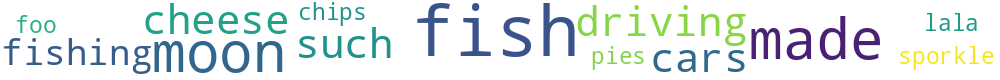

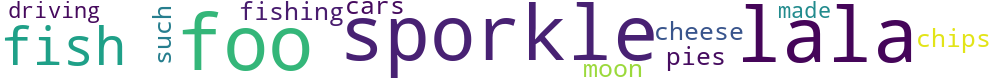

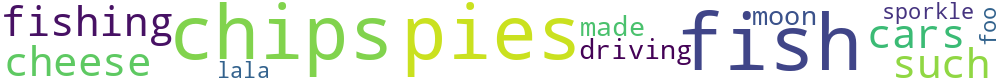

In [340]:
## Testing basic function.  Note that we expect the output to be terrible, we give it almost no input.
gf = GensimFiddle()
gf.add_doc_by_tokens( text2tokens('I like fish and fishing', stop=stop_en) )
gf.add_doc_by_tokens( text2tokens('fish and chips and pies', stop=stop_en) )
gf.add_doc_by_tokens( text2tokens('cars and driving and such', stop=stop_en) )
gf.add_doc_by_tokens( text2tokens('Sporkle foo lala', stop=stop_en) )
gf.add_doc_by_tokens( text2tokens('The moon is made of cheese or fish', stop=stop_en) )
#gf.all_doccounts()
gf.run_lda(num_topics=3)
display( gf.show_topics() )
gf.display_top_terms()
gf.display_top_wordclouds()

## LDA experiment on 20 newsgroups

The "20 newsgroups" dataset is a sampling of [usenet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) (forum-like things) from a while ago.

It's a dataset to test methods, because we know 
they broadly keep to the topic they are in
the messages are small, so probably many of the words contribute.

We also know where they belong from their group name (things like 'alt.atheism', 'talk.religion.misc', 
'sci.space','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey')
but let's throw away that knowledge, and have our test be whether we would rediscover those patterns.

### Fetching text

In [45]:
tng_docs = read_20newsgroups()
print( len(tng_docs) )

18840


In [118]:
# show one example message
choice = random.choice(tng_docs)

# the plain text
print( choice ) 

# see what the tokenization leaves us with
text2tokens(choice, stop_en)

I am boring my sister HP DeskJet 500C for the weekend and I was wondering
in their was any drivers for it available some where that would allow
me to use it with my Mac SE/30.  I have a copy of MacPrint but I do think
that I have a driver for the 500C.  I would be happy to get it working
in black & white, but if there is away to get the color working that would
be better.  Any ideas someone?

Regards,


-- 
Robert R. Hardesty			hardesty@meiko.com
Customer Support Engineer		Tele: (617) 890-7676
Meiko Scientific Corporation		Fax: (617) 890-5042
1601 Trapelo Rd.  			Waltham, MA 02154


['am',
 'boring',
 'sister',
 'hp',
 'deskjet',
 'weekend',
 'wondering',
 'drivers',
 'available',
 'where',
 'allow',
 'use',
 'mac',
 'se',
 'copy',
 'macprint',
 'think',
 'driver',
 'happy',
 'working',
 'black',
 'white',
 'away',
 'color',
 'working',
 'better',
 'ideas',
 'someone',
 'regards',
 'robert',
 'hardesty',
 'hardesty',
 'meiko',
 'customer',
 'support',
 'engineer',
 'tele',
 'meiko',
 'scientific',
 'corporation',
 'fax',
 'trapelo',
 'rd',
 'waltham',
 'ma']

In [139]:
# Given the modest size of 20newsgroups data, (re-)running this may take a minute or two

gf = GensimFiddle()

# add the documents
for doc_text in tng_docs: 
    gf.add_doc_by_tokens( text2tokens(doc_text, stop=stop_en) )

# Run analysis with a specific idea of how many topics we want.
gf.run_lda( num_topics=20 )
#  The target amount of topics is in general an an estimation, and a choice of how general/specific we try to be.

What did we achieve?  What do we have?

Well, let's pick one of the three models we trained, 
get it to show us its topics (which are not labeled, just numbered),
and for each topic their top terms, and their contribution

In [140]:
gf.show_topics(num_topics=10, num_words=10, formatted=True)  # default is formatted=True;  False gives it as data

[(19,
  '0.017*"jpeg" + 0.014*"gif" + 0.011*"objective" + 0.010*"abortion" + 0.008*"image" + 0.008*"rochester" + 0.007*"color" + 0.007*"dyer" + 0.006*"clarkson" + 0.005*"images"'),
 (11,
  '0.010*"turkish" + 0.009*"armenian" + 0.009*"armenians" + 0.007*"turkey" + 0.005*"turks" + 0.005*"armenia" + 0.004*"don" + 0.003*"now" + 0.003*"know" + 0.003*"people"'),
 (0,
  '0.007*"islam" + 0.006*"muslims" + 0.006*"islamic" + 0.005*"qur" + 0.004*"muslim" + 0.004*"could" + 0.003*"evidence" + 0.003*"theory" + 0.003*"does" + 0.003*"science"'),
 (2,
  '0.007*"drive" + 0.006*"two" + 0.005*"new" + 0.005*"off" + 0.005*"back" + 0.004*"car" + 0.004*"time" + 0.004*"game" + 0.004*"know" + 0.004*"myers"'),
 (14,
  '0.011*"people" + 0.006*"israel" + 0.005*"jews" + 0.004*"because" + 0.004*"her" + 0.004*"she" + 0.004*"don" + 0.003*"children" + 0.003*"even" + 0.003*"against"'),
 (13,
  '0.011*"game" + 0.007*"games" + 0.007*"team" + 0.007*"year" + 0.006*"runs" + 0.006*"last" + 0.005*"baseball" + 0.005*"won" + 0.0

Fine, but that's hard to read.  How about something more compact?  (...or visual? There's a wordcloud thing too)

In [141]:
gf.display_top_terms( phrase_thresh=0.3, num_words=100 )

### Matching text

In [142]:
for unseen_text in (
    "I like apple macintosh computers and do not do backups onto floppy drives missingtoken",
    "I believe god likes an atheist, gives them something to aim at",
    "A new car is a joy to drive, stick shift is hard to control on the road",
):
    print( '=== Query: %r ==='%unseen_text )
    for score, topic_num in gf.query( unseen_text ):
        gf.display_top_terms(filter_topics=[topic_num] )


=== Query: 'I like apple macintosh computers and do not do backups onto floppy drives missingtoken' ===


=== Query: 'I believe god likes an atheist, gives them something to aim at' ===


=== Query: 'A new car is a joy to drive, stick shift is hard to control on the road' ===


All that looks okay -- but that is for a good part because we spent an hour tweaking that.

If nothing else, you can use it for exploration, inspiration to make your own classifier or such, suggest related terms, or whatnot.


Still, it's not too bad for something that does not even knows what words are,
and just considers them certain _things_ that appear together.

Some of those topics even look useful, some coherent enough that you might give them your own labels,
but others are messy and hard to explain.

Where this example gets away with some cherry picking, 
in the real world, if it doesn't really work, you  move on.

**It is very much suggested to play with this to see how much you can break it.**

### Visualization

People have made visualizations of the results, which may also do some further analysis.

In [143]:
# Side note: It seems that pyLDAvis isn't the best-maintained package
# and there are specific pandas-and-python version combinations under which it will fail. It's not you.
# If you get an error mentioning drop(), you may need py >= 3.9 the get the pyLDAvis update that fixes that

import pyLDAvis
import pyLDAvis.gensim
import pandas

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(gf.lda, gf.corpus, gf.dic) # this does some further number crunching.
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.136009 -0.061031       1        1  16.069343
6      0.055456  0.131862       2        1   9.095806
14     0.140168 -0.125290       3        1   9.070335
10     0.038963  0.170193       4        1   8.199388
9      0.021061  0.212601       5        1   7.952661
15     0.131811 -0.087095       6        1   7.829077
7      0.056391 -0.022551       7        1   6.554322
18     0.117074 -0.035815       8        1   6.036106
2      0.007856  0.009925       9        1   4.141037
5      0.023950 -0.080799      10        1   4.043691
17     0.049817  0.090954      11        1   3.822443
13    -0.010927 -0.072162      12        1   3.434438
11     0.030043 -0.074846      13        1   2.999626
8      0.000983 -0.088148      14        1   2.538408
4     -0.305352 -0.124938      15        1   1.871995
3     -0.076062  0.142334      16        1   1.836653
12    -0.061889  0.028913      17        1   1.829968
0     -0.022071 -0.024928      18        1   1.322874
19    -0.189551  0.027736      19        1   0.760785
16    -0.143729 -0.016917      20        1   0.591045, topic_info=              Term         Freq        Total Category  logprob  loglift
3267           god  6551.000000  6551.000000  Default  30.0000  30.0000
587            max  3064.000000  3064.000000  Default  29.0000  29.0000
2427           key  2453.000000  2453.000000  Default  28.0000  28.0000
1998           dos  2673.000000  2673.000000  Default  27.0000  27.0000
1739       windows  3470.000000  3470.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
5047           sex    73.939145   710.388157  Topic20  -5.3281   2.8685
6352           gay    52.172002   416.619332  Topic20  -5.6768   3.0534
14732  orientation    38.432608   164.313647  Topic20  -5.9824   3.6782
6684       exhibit    34.851796   157.838276  Topic20  -6.0802   3.6206
278            use    36.868711  7218.793613  Topic20  -6.0240  -0.1460

[1701 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4989     20  0.950458       aap
8760      2  0.004904  abortion
8760      9  0.009809  abortion
8760     18  0.009809  abortion
8760     19  0.971080  abortion
...     ...       ...       ...
7581     10  0.013991       zoo
7581     17  0.937364       zoo
7581     19  0.020986       zoo
3916     10  0.010726   zoology
3916     17  0.965315   zoology

[9483 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 15, 11, 10, 16, 8, 19, 3, 6, 18, 14, 12, 9, 5, 4, 13, 1, 20, 17])

The circles on the left each represent a topic.
- circle size is how well represented this topic is                          - often meaning that more of its words are common?
- circle position is based on how dissimilar we think different topics are   - based on additional analysis this visualization adds, and was not part of the topic model

The bars also have more going on than in the model.
- blue bars show how common the term is in general,   (...showing the subset of term in the topic we are currently looking at)
- the red bars within a blue bar _estimate_ how important this term is within the current topic (keep in mind each term is a member of _multiple_ topics)
- the 'relevance metric' slider controls how terms are sorted (and how the red is) 
  - To the right sorts by frequency within the model
  - To the left sorts by how much a term stands out between topics
  - inbetween blends those two, which seems most useful to interpret the topic
  - the most common terms stay on top, but playing with that slider helps discover what the topic is about

## LDA experiment with more natural text

[Internetconsulataties](https://www.internetconsultatie.nl/) is the government asking for public opinions about proposed laws and such.

The below pick a specific case, namely people talking restricting fireworks, 
in part because there are a lot of responses in it, 
and in part because people are fired up and we might be able to find that more emotional argument.

In [151]:
from wetsuite.helpers.notebook import ProgressBar

# We remove some words from the analysis because we expect it to be in everthing.
vuur_stoplist = stop_nl+[  'vuurwerk','verbod',   'jaar', 'jaarlijks',   'illegaal', 'verbieden',   'algemeen']

vuur = GensimFiddle()
for reactie in vuurwerk_reacties():
    vuur.add_doc_by_tokens( text2tokens(reactie, stop=vuur_stoplist) )

In [152]:
vuur.run_lda( num_topics= 15) # might take a minute  

In [153]:
vuur.display_top_terms( phrase_thresh=0.3, num_topics=50, num_words=50 )

In [156]:
vis = pyLDAvis.gensim.prepare(vuur.lda, vuur.corpus, vuur.dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.072652 -0.035881       1        1  14.702500
7      0.078386  0.015152       2        1  12.557881
4      0.069624  0.032394       3        1  12.173292
14     0.107283 -0.003182       4        1  10.077766
3      0.064073 -0.052961       5        1   8.805961
12     0.046918  0.012864       6        1   6.455909
9      0.017516  0.006515       7        1   5.632314
0      0.055002 -0.017107       8        1   5.415173
13    -0.075948 -0.015466       9        1   5.347850
6     -0.188622 -0.169908      10        1   5.104479
10    -0.022696  0.011863      11        1   4.541180
1     -0.040323  0.049122      12        1   3.016479
5      0.023432 -0.041075      13        1   2.976854
2     -0.066934  0.030792      14        1   1.945227
8     -0.140364  0.176881      15        1   1.247134, topic_info=                Term         Freq        Total Category  logprob  loglift
303         traditie  3811.000000  3811.000000  Default  30.0000  30.0000
1             dieren  1141.000000  1141.000000  Default  29.0000  29.0000
7             minder   820.000000   820.000000  Default  28.0000  28.0000
757           milieu   738.000000   738.000000  Default  27.0000  27.0000
124            werkt   567.000000   567.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
259   vuurwerkverbod    24.445291  3292.236669  Topic15  -5.1304  -0.5186
368      nederlandse    20.235156   814.971575  Topic15  -5.3194   0.6886
384     knalvuurwerk    20.133744   848.789784  Topic15  -5.3244   0.6429
91            veilig    19.036244  1135.656736  Topic15  -5.3805   0.2957
1015      gevaarlijk    18.493820   507.155354  Topic15  -5.4094   1.0729

[1234 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1546      6  0.110546      aanbod
1546      7  0.073698      aanbod
1546      8  0.700127      aanbod
1546      9  0.092122      aanbod
5066      7  0.847407  aangeboden
...     ...       ...         ...
2420      9  0.020545      zwarte
2420     11  0.061634      zwarte
2420     12  0.020545      zwarte
2420     13  0.010272      zwarte
6050      3  0.942122   zwijgende

[4930 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 8, 5, 15, 4, 13, 10, 1, 14, 7, 11, 2, 6, 3, 9])

## LDA experiment on some legal text

Consider what we've done:
- In 20newsgroups, each document was a small thing staying broadly within a topic
  and with many of the words contributing to that topic.

- In the vuurwerk reacties, we were perhaps looking more for what kind of terms co-occur,
  and might _possibly_ use that match it to a particular kind of argument, or vibe.

Legal text, on the other hand, is not short, 
generally does not have most words contributing to a singular overall topic,
and presumably has a lot of overlap in word use.

Let's feed it some, and see what happens. 
Let's 
- look at some different kinds of text
- feed shorter fragments in at a time (currently tries for paragraphs and this may be overly short - we might increase that to longer sections where we can)

Note that a full set of any one source will have tens or hundreds of thousands of documents,
Just tokenizing those will take only a few minutes. 

Most of the implied time is actually in the analysis step because techniques like LDA 
high time complexity - runtime rises somewhat unreasonably with ain increased amount of input,
so for quick experments, keep the doc count down to perhaps ~10K documents worth,
so that that analysis takes only a few minutes.

In [157]:
legal_text_docs = legaltext()
len(legal_text_docs)

60000

In [ ]:
lt = GensimFiddle()
for reactie in legal_text_docs:
    lt.add_doc_by_tokens( text2tokens(reactie, stop=stop_nl+'zou kunnen blijkt zie hen doen we die de dit het'.split()) )

In [14]:
# that's a sizeable amount of things - this takes three hours
lt.run_lda( num_topics=300 )

In [20]:
lt.display_top_terms( phrase_thresh=0.25, num_topics=100, num_words=50 )

Not great. Let's move on to do some comparison:

## On other methods

So far we've used one specific method - LDA-based, which is a statistical model that tries to fit co-occurrences.
It's not aware of words at all - so most of the co-occurrences will be common words, because that's... true.

Some other methods used include
- LSI and LSA can be considered precursors to the LDA approach. They're crude, let's not try them here
- NMF (non-negative matrix factorization), which you can consider a variant of LDA. There is a soft consensus that LDA tends to be more coherent
- [doc2vec-based](https://en.wikipedia.org/wiki/Word2vec#Extensions) Top2Vec
- [BERTopic](https://maartengr.github.io/BERTopic/index.html)

See e.g. [some comparison](https://web.archive.org/web/20240504061214/http://www.datascience-in-tourism.com/?p=550).


Note that of the variants that try word embeddings, some try to learn those embeddings,
others just use existing embeddings
- Learning them may be better at specializing, but requires a lot of text and is slow;
- existing embeddings can be fast, and good enough if the earlier training covered your uses 

## Top2vec

Notes:
* we are skipping all of the "this is how it works and how to use it", just showing you some results

* Top2Vec constructor's 
  - `speed` is one of  `fast-learn` (but lower quality), `learn` (balanced), `deep-learn` (better but slow)

* the `model_filename` stuff is us adding a "if we've run this before and save that model, load it"

* from some experiments
  - doc2vec is _not_ great with a lower amount of documents - but decent if you're willing to give it more
  - most other methods work from existing vectors, which is why they are pretty decent een with much less input (but they won't know certain words)

## Experiment: Top2vec on legal text


In [ ]:
import top2vec   #if that gives an error, you probably need a    !pip3 install top2vec

In [215]:
#document_sample = random.sample(legal_text_docs, 5000) # small set during debug?
# large documents seem to run the GPU (if used) out of memory, we can miss a few
# tiny documents may be empty or just say 'vervallen'
document_sample = list(txt  for txt in legal_text_docs   if len(txt)<100000 and len(txt)>1000) 
print( len( document_sample ) )

52082


In [162]:
# this took 10 mins for 5000, or 90 mins for 50000, using 6 CPU cores
t2v_d2v_model_filename = "model-doc-doc2vec-4"
if os.path.exists( t2v_d2v_model_filename ) and True:
    print( "LOADING %s"%t2v_d2v_model_filename )
    t2v_d2v_model = top2vec.Top2Vec.load( t2v_d2v_model_filename )
else:
    print( "GENERATING %s"%t2v_d2v_model_filename )

    t2v_d2v_model = top2vec.Top2Vec(
        #documents = document_sample,
        documents = random.sample(document_sample, 50000),
        embedding_model='doc2vec', # slower but won't OOM the GPU
        speed='learn', 
        workers=8,
        umap_args={'n_neighbors': 5,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
        },
        hdbscan_args = {
            'min_cluster_size': 10,
            'min_samples':5,
            'metric': 'euclidean',
            'cluster_selection_method': 'eom'
        }
    )
    print( "SAVING %s"%t2v_d2v_model_filename )
    t2v_d2v_model.save( t2v_d2v_model_filename )

LOADING model-doc-doc2vec-4


In [163]:
topic_words, word_scores, topic_nums = t2v_d2v_model.get_topics() # you can ask for fewer
print('Amount of topics:',len(topic_nums))
for topic_num in topic_nums:
    estimated_coherence = sum(word_scores[topic_num][:20])/len(word_scores[topic_num][:20])
    words = ', '.join( topic_words[topic_num])

    print(  f"topic {topic_num:2d} (coherence {estimated_coherence:.2f}):  {words}" )

Amount of topics: 981
topic  0 (coherence 0.41):  neerslag, actoren, beleidsterrein, selectielijst, ressorterende, gevoegde, staatscourant, bsd, regeringsbeleid, wetenschappen, selectielijsten, stcrt, rijksbegroting, direkt, geplaatst, gepubliceerd, ocenw, departement, lnv, cultuur, oenw, senternovem, nuffic, constitutionele, trcjz, minister, technologie, buitenlandse, uitgifte, doorverlenen, wetenschap, dienstonderdeel, doorverlening, directies, universitair, oeso, goedkeuren, directoraat, landbouw, universiteit, bve, akademie, natuurbeheer, personeelszaken, landinrichting, handelingen, biologie, eindexamens, toelichting, minderheden
topic  1 (coherence 0.82):  gi, minderjarige, moeder, omgangsregeling, vader, omgang, contactregeling, contactherstel, jeugdbeschermer, raadsrapport, gezinsvoogd, thuisplaatsing, kinderrechter, raadsonderzoek, opvoedsituatie, zorgregeling, omgangsmomenten, moederszijde, ouderlijk, eenhoofdig, gezinshuis, bezoekregeling, jbra, schoolgang, grootmoeder, plee

Okay, that actually seems a bunch better.

...but try running that with just 5000. Not as good. So you do need this to run a good while.


What if we try a variant that focuses more on knowledge of words it knows already (rather than trying to learn them)?

In [ ]:
# This seems to take ~10min for 60k documents (on GPU)

t2v_use_model_filename = "model-doc-use-2"
if os.path.exists( t2v_use_model_filename ) and True:
    print( "LOADING %s"%t2v_use_model_filename )
    t2v_use_model = top2vec.Top2Vec.load( t2v_use_model_filename )
else:
    print( "GENERATING %s"%t2v_use_model_filename )

    t2v_use_model = top2vec.Top2Vec(
        documents = document_sample,
        embedding_model='universal-sentence-encoder-multilingual',
        speed='learn', 
        workers=2,
        umap_args={'n_neighbors': 5,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
        },
        hdbscan_args = {
            'min_cluster_size': 10,
            'min_samples':5,
            'metric': 'euclidean',
            'cluster_selection_method': 'eom'
        }
    )
    print( "SAVING %s"%t2v_use_model_filename )
    t2v_use_model.save( t2v_use_model_filename )

Okay, what does _that_ model represent?

What's in there?

In [217]:
topic_words, word_scores, topic_nums = t2v_use_model.get_topics() # note: you can ask for fewer than all
print('Amount of topics:',len(topic_nums))
for topic_num in topic_nums:
    estimated_coherence = sum(word_scores[topic_num][:20])/len(word_scores[topic_num][:20])
    words = ', '.join( topic_words[topic_num])
    print(  f"topic {topic_num:2d} (coherence {estimated_coherence:.2f}):  {words}" )

Amount of topics: 785
topic  0 (coherence 0.20):  beroepsgericht, beroepszaak, beroepsgerichte, facultatieve, applicant, landsadvocaat, keuzerecht, beroep, optierecht, beroepstermijn, beroepschrift, facultatief, beroepskracht, beroepsmilitair, rechtspraak, beroepsschrift, rechtzoekende, beroeps, ontslagaanvraag, rechtskeuze, landgericht, arbitraal, tuchtrechtelijk, beroepen, beroepsfout, beroepservaring, hofuitspraak, claimverzoek, rechtzoekenden, attorney, tuchtrecht, hoofdadvocaat, rechterlijke, appeal, grondrecht, gerechtelijke, tribunaal, rechtsvraag, beroepskrachten, beroepshalve, arbitration, appelrechter, beroepsmatig, faculteit, ontslagdatum, beroept, uitspraakdatum, jurisdiction, beroepswet, fosfaatrecht
topic  1 (coherence 0.23):  strafrechtelijk, strafrechter, strafontslag, strafbedreiging, veroordeelde, veroordeelden, strafbaar, crimes, strafvervolging, strafrecht, slachtofferhulp, slachtofferzorg, slachtoffers, strafmotivering, veroordeeld, slachtoffer, jeugdstrafrecht, st

In [218]:
words, scores = t2v_use_model.similar_words(['arrest', 'cassatie'], 15)

for word, score in zip( words, scores):
    print( f'{score:4.2f}  {word}' )

0.82  arresten
0.80  arrestatie
0.77  voorarrest
0.77  gearresteerd
0.75  schending
0.75  strafgeding
0.74  strafeis
0.74  gevangen
0.74  bekrachtigt
0.74  vervolgd
0.73  strafzaken
0.73  fundering
0.73  criminal
0.73  straf
0.73  cassatiemiddel


In [223]:
# Let's pick out a topic that we know is there  (note: this only works for words it does know)
words, ws, ts, tn = t2v_use_model.search_topics(keywords=['jeugdhulp'], num_topics=1)
print( words )
jeugd_topic = tn[0]

[array(['jeugdhulp', 'jeugdlid', 'jeugdbeleid', 'jeugdwet', 'jeugdzorg',
       'jeugdleden', 'jeugdrecht', 'jeugdpsychiater', 'jeugdbeschermer',
       'jeugd', 'jeugdigen', 'jeugdinrichting', 'minimumloon',
       'jeugdconsulent', 'jeugdige', 'kinderbijdrage', 'minimumbedrag',
       'kinderkorting', 'minimumtermijn', 'jeugdraad', 'minimumnormen',
       'minderjarigen', 'jeugdstrafrecht', 'jonger', 'minderjarige',
       'pensionkosten', 'pensionering', 'kindertoelage', 'ondervangen',
       'kinderopvang', 'leeftijdsbedrag', 'child', 'jongere', 'jonge',
       'jeugdarts', 'jeugdhonken', 'subsidiejaar', 'schoolbudget',
       'tariefklasse', 'minimabeleid', 'minimaal', 'subsidievorm',
       'minimumaantal', 'junior', 'pensioenbedrag', 'jong',
       'pensioenpremie', 'jongeren', 'schoolkosten', 'pgb'], dtype='<U15')]


In [224]:
# And let's see some documents about that.  
documents, document_scores, document_ids = t2v_use_model.search_documents_by_topic(topic_num=jeugd_topic, num_docs=5)
documents

array(['Begripsbepalingen \nDe begripsbepalingen die in dit besluit worden gebruikt, hebben dezelfde betekenis als in de Jeugdwet, Besluit Jeugdwet en de Verordening. In dit besluit en de daarop berustende bepalingen wordt verstaan onder:\nBehandeling: behandeling door een jeugdhulpaanbieder, al dan niet met verblijf.\nBudgethouder: de persoon aan wie het budget wordt verstrekt.\nCJG: Centrum voor Jeugd en Gezin.\nCollege: college van burgemeester en wethouders.\nGemeente: gemeente Woudrichem. De gemeente heeft de uitvoering van de gemeentelijke taken met betrekking tot de toegang tot jeugdhulp gemandateerd aan het CJG.\nIndividuele voorziening: de gemeente biedt individuele (niet vrij-toegankelijke) jeugdhulpvoorzieningen, namelijk op de jeugdige of zijn ouders toegesneden voorzieningen, als bedoeld in artikel 2 tweede lid van de verordening, waarvoor een beschikking van het college nodig is.\nLogeerzorg: logeren in een zorginstelling of binnen het sociaal netwerk, maximaal 156 etmale

In [266]:
# There's a bunch of search functions, like search_documents_by_topic, search_documents_by_documents, search_documents_by_keywords, etc.

# For example, to prove a point, the word 'jeugdhulp' does not appear literally in all matchdes
#   ...which is in part because this is all documents sorted and less than ~700 do,
#   yet an inspection of these not-literally-there in the top so-many will show they are  still semantically close
documents, doc_scores, doc_ids = t2v_use_model.search_documents_by_keywords(['jeugdhulp'], num_docs=100 )

yes, no = 0, 0
for i, doc in enumerate(documents):
    #print( i, repr(doc) )
    if 'jeugdhulp' not in doc:
        no += 1
    else:
        yes += 1
        #print(doc)
yes, no

(77, 23)

## Experiment: top2vec on fireworks

If it's so great, let's try it at the messy vuurwerkverbod thing again.

In [287]:
reactie_list = data_vuurwerk_reacties()

# remove this line and you'll see why it's here  (they'll also be missing from the documents later, but fine)
reactie_list = list( re.sub(r'(\bvuurwerk\b|\bvuurwerkverbod\b)',' ',txt)  for txt in reactie_list)

vuurt2v_model_filename = 'vuur_model_20'
if os.path.exists( vuurt2v_model_filename ) and True:
    print( "LOADING %s"%vuurt2v_model_filename )
    vuurt2v_model = top2vec.Top2Vec.load( vuurt2v_model_filename )
else:
    print( "GENERATING %s"%vuurt2v_model_filename )
    
    vuurt2v_model = top2vec.Top2Vec(
        documents = reactie_list,
        embedding_model='universal-sentence-encoder-multilingual', # seems to use existing vectors
        speed='deep-learn', 
        workers=2,
        umap_args={'n_neighbors': 40,
             'n_components': 7,
             'metric': 'cosine',
             "random_state": 42
        },
        hdbscan_args = {
            'min_cluster_size': 16,
            'min_samples':5,
            'metric': 'euclidean',
            'cluster_selection_method': 'eom'
        }
    )
    print( "SAVING %s"%vuurt2v_model_filename )
    vuurt2v_model.save( vuurt2v_model_filename )

2024-08-16 17:52:05,347 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


GENERATING vuur_model_20


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-08-16 17:52:06,592 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-08-16 17:52:07,654 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-08-16 17:52:13,229 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-08-16 17:52:28,904 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:F

SAVING vuur_model_20


In [288]:
topic_words, word_scores, topic_nums = vuurt2v_model.get_topics() # you can ask for fewer
print('Amount of topics:',len(topic_nums))
for topic_num in topic_nums:
    estimated_coherence = sum(word_scores[topic_num][:20])/len(word_scores[topic_num][:20])
    words = ', '.join( topic_words[topic_num])
    print(  f"topic {topic_num:2d} (coherence {estimated_coherence:.2f}):  {words}" )

Amount of topics: 57
topic  0 (coherence 0.29):  traditie, tradities, oudejaarsavond, gewone, oudjaarsavond, vroeger, altijd, normaal, gewoon, nooit, voorafgaand, verboden, tegenwoordig, misbruik, misbruiken, gebruiken, verbod, voordat, gebruikt, eerder, gebruik, voorkomen, oude, verbieden, vaak, normale, blijft, blijven, strengere, illegaal, verkeerde, elders, streng, nederlandse, illegale, huidige, voornamelijk, voorkomt, verbied, wederom, particulieren, oudjaar, verschrikkelijk, meestal, cultuur, onnodig, daarvoor, doorgaan, nauwelijks, straffen
topic  1 (coherence 0.23):  oudejaarsavond, oudjaarsavond, jaar, nieuwjaar, oudjaar, oudjaarsdag, jaarlijks, jaarlijkse, traditie, tradities, oude, jaarwisseling, vuurwerk, feest, elders, jaarwisselingen, iedereen, vuurwerkverbod, vuurpijlen, jarenlange, nieuw, januari, maand, gevaarlijker, jeugd, vuurwerkshows, jaren, vuurwerkshow, gevaarlijke, gewonden, eerlijk, vuurwerkbril, belachelijk, tegenwoordig, nieuwe, gevaarlijk, vuurwerkbranche, 

That seems like an improvement, but it took various runs with cluster-size targets to get this.

Still, consider that in theory, someone read those ~11K responses.
Something like this might have helped.

In [326]:
# There's a bunch of search functions, like search_documents_by_topic, search_documents_by_documents, search_documents_by_keywords, etc.

# For example, to prove a point, the word 'jeugdhulp' does not appear literally in all matchdes
#   ...which is in part because this is all documents sorted and less than ~700 do,
#   yet an inspection of these not-literally-there in the top so-many will show they are  still semantically close
documents, doc_scores, doc_ids = vuurt2v_model.search_documents_by_keywords( 
    keywords=[
        #'oplossing', # see if using a term like that may finds documents of people thinking more productively (...that depends on the model, actually)
        #'illegaal', # and maybe addressing things we consider part of the problem
        #'dieren',
        #'traditie',
    ], 
    keywords_neg=[
        'belachelijk','verschrikkelijk','absurd','onzin','betutteling','straf','afpakken', # okay, what about with fewer emotional responses
        'gezondheid', 'dieren', 'traditie'                                                 # and reasons other than ones we've already seen
    ],
    num_docs=100 )

for doc in enumerate(documents):
    print(doc)

# the empty spaces were the 'vuurwerk' and 'vuurwerkverbod' we removed from everything. 
# We may not want to do that after all, it just made the topics looks nicer.

(0, 'Dit is een initiatief dat letterlijk niks zal bijdragen aan het verminderen van "vuurwerkoverlast". Al het "vuurwerkoverlast" wordt veroorzaakt door professioneel   dat toch al verboden is en als "bommen" worden aangezien door politie en media (beide links georiënteerd). Dit soort "criminaliteit" zal exponentieel uitbreiden wanneer dit kansloze initiatief vanuit twee politieke partijen, die een bepaald en beperkt soort mensen aantrekt, zal worden doorgevoerd.')
(1, 'Ik steun dit voorstel NIET. Inhoudelijk kan ik mij niet vinden in het voorstel, zie ik de basis motieven anders dan de indieners van dit voorstel en past mij de vorm van uitvoering allerminst.')
(2, 'Ik ben tegen een  . Ik sluit mij aan bij de argumenten van medestanders die via de internetconsultatie ook kenbaar gemaakt hebben tegen een  .\nIk wil als een van de laatste reageerders nog het volgende zeggen (ook tegen pvdd en gl)\nGUN MEKAAR WAT (8 uurtjes  ), DAT LEIDT TOT MEER WEDERZIJDS RESPECT en BEGRIP ipv POLARISA